In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit

In [72]:
sns.set()
%matplotlib inline

In [73]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
%autoreload 2

In [75]:
from sir_models.seir import SEIR
from sir_models.utils import stepwise, get_quarantine_multiplier_value

# Load data

In [202]:
df = pd.read_csv('data/data.csv', sep=';')

In [203]:
df.columns = ['date', 'region', 'total_infected', 'total_recovered', 'total_dead', 'deaths_per_day', 'infected_per_day', 'recovered_per_day']
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

df['infected'] = df['total_infected'] - df['total_recovered'] - df['total_dead']

In [204]:
df = df[df.region == 'Москва'].reset_index()
#df = df.groupby('date').sum().reset_index()

In [205]:
df.head()

,index,date,region,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected
0,40,2020-03-12,Москва,21,0,0,0,21,0,21
1,122,2020-03-13,Москва,26,0,0,0,5,0,26
2,204,2020-03-14,Москва,35,0,0,0,9,0,35
3,286,2020-03-15,Москва,35,1,0,0,0,1,34
4,368,2020-03-16,Москва,53,1,0,0,18,0,52


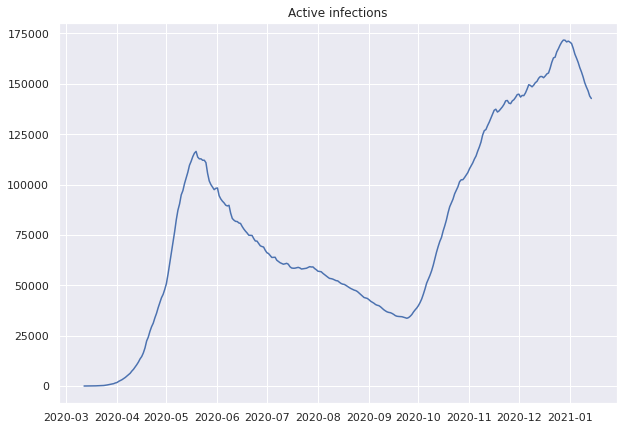

In [206]:
plt.figure(figsize=(10,7))
plt.plot(df.date, df.infected)
plt.title("Active infections")
plt.show()

# Model

In [207]:
train_subset = df[(df.date >= '2020-03-25') & (df.date <= '2020-11-30')]

In [208]:
test_subset = df[df.date > train_subset.iloc[-1].date]
test_subset.date[:3]

264   2020-12-01
265   2020-12-02
266   2020-12-03
Name: date, dtype: datetime64[ns]

In [209]:
model = SEIR()
model.fit(train_subset)

(S, E, I, R, D), history = model.predict_train()

result = model.fit_result_
result

2.5647635439280845 46.898375511692066 18.622455102890786
2.5647635439280845 46.898375511692066 18.622455102890786
2.5647635439280845 46.898375511692066 18.622455102890786
2.56476358156565 46.89837584605973 18.622455305972267
2.5647635423335777 46.89837513191401 18.62245509021113
2.564763540464327 46.89837546376357 18.622455084537673
2.5647635410875957 46.89837547215606 18.62245508873472
2.5647635430490126 46.89837549930646 18.622455098711427
2.5647635438354928 46.898375510640996 18.62245510245949
2.5647635439210976 46.898375511583936 18.622455102858407
2.5647635439278034 46.89837551168939 18.62245510288951
2.564763561348995 46.89837552119475 18.622455105012133
1.1782790981167055 23.894752439311407 10.382632424056105
1.178279141852126 23.894752980048356 10.382632611678906
1.1782791331343532 23.894752857224564 10.382632571625349
1.1782791117861344 23.894752603861853 10.38263248103373
1.1782790840286068 23.89475227298792 10.38263236461334
1.1782791310219347 23.89475281843173 10.3826325583

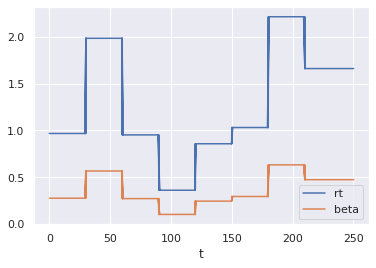

In [215]:
plt.figure()
history.rt.plot()
history.beta.plot()
plt.legend()
plt.show()

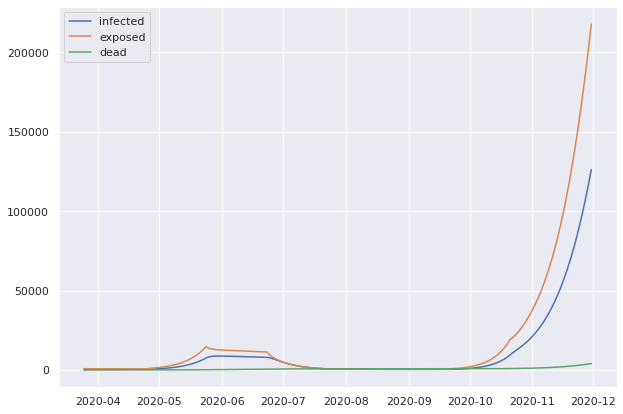

In [216]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, I, label='infected')
plt.plot(train_subset.date, E, label='exposed')
plt.plot(train_subset.date, D, label='dead')
plt.legend()
plt.show()

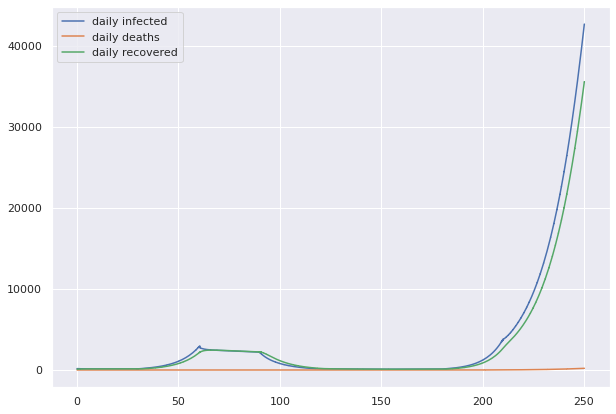

In [217]:
plt.figure(figsize=(10, 7))
plt.plot(history.new_infected, label='daily infected')
plt.plot(history.new_dead, label='daily deaths')
plt.plot(history.new_recovered, label='daily recovered')
plt.legend()
plt.show()

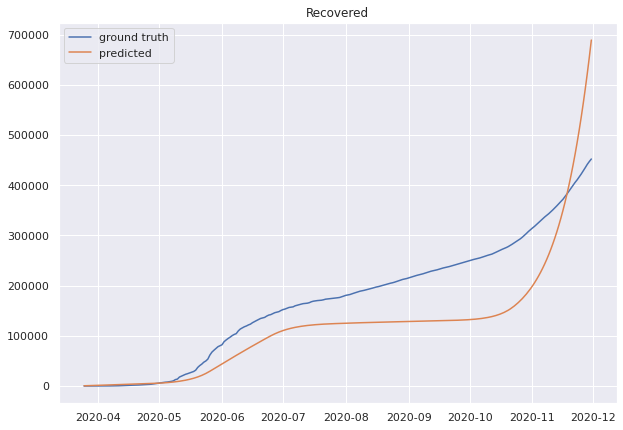

In [218]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_recovered'], label='ground truth')
plt.plot(train_subset.date, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

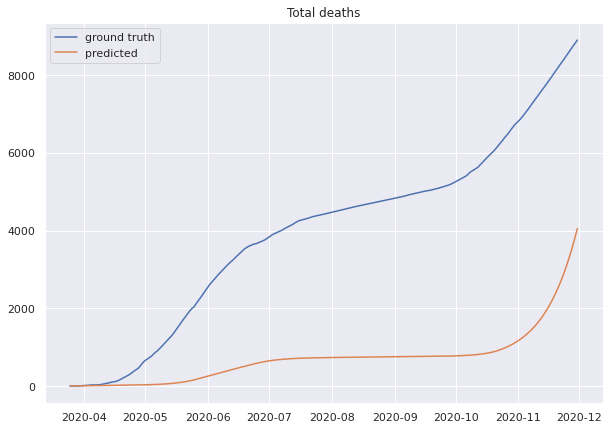

In [219]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

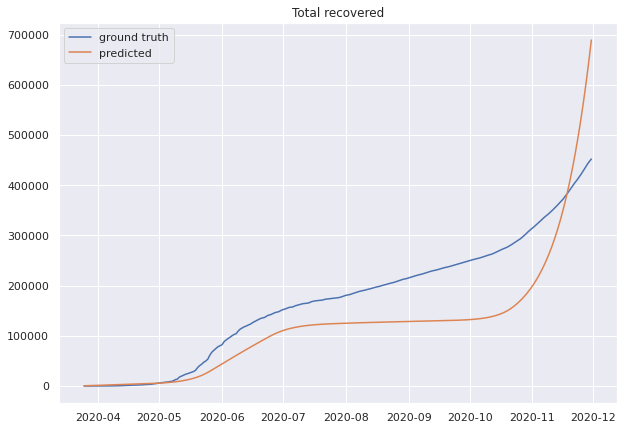

In [220]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_recovered'], label='ground truth')
plt.plot(train_subset.date, R, label='predicted')
plt.legend()
plt.title('Total recovered')
plt.show()

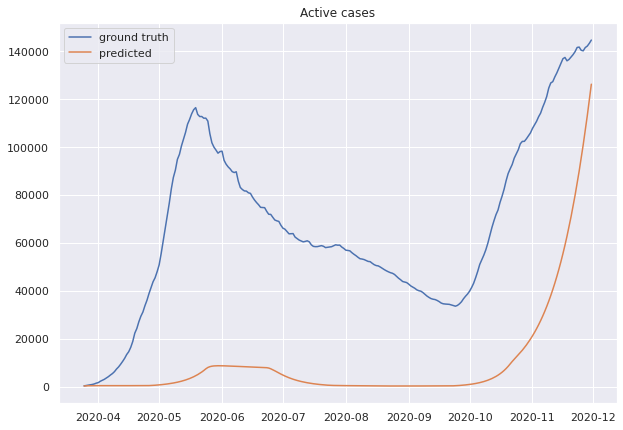

In [221]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='ground truth')
plt.plot(train_subset.date, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

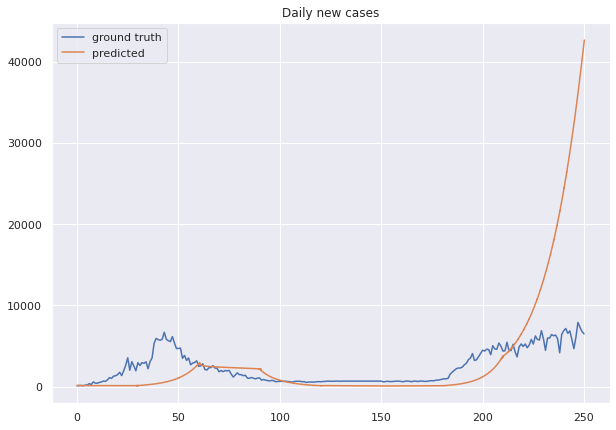

In [223]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_subset)), train_subset['infected_per_day'], label='ground truth')
plt.plot(history.new_infected, label='predicted')
plt.legend()
plt.title('Daily new cases')
plt.show()

# Obtain forecast

In [224]:
test_t = len(train_subset) + np.arange(len(test_subset))

(test_S, test_E, test_I, test_R, test_D), history = model.predict_test(test_t)

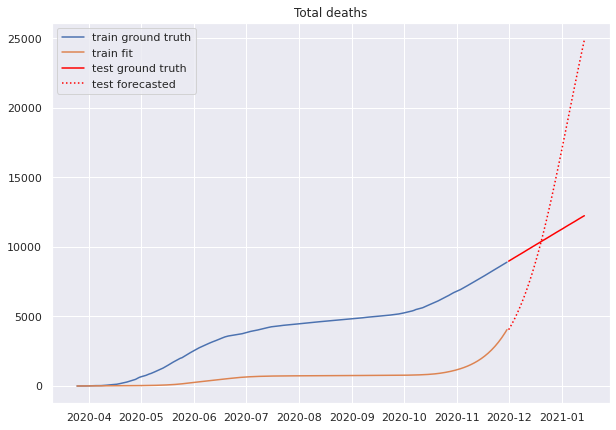

In [225]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='train ground truth')
plt.plot(train_subset.date, D, label='train fit')

plt.plot(test_subset.date, test_subset['total_dead'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_D, label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Total deaths')
plt.show()

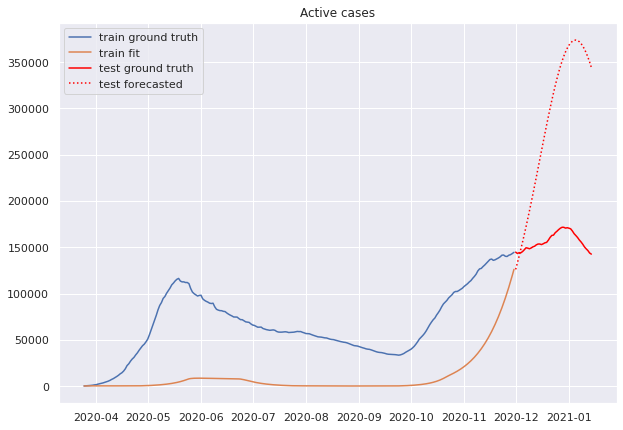

In [226]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='train ground truth')
plt.plot(train_subset.date, I, label='train fit')

plt.plot(test_subset.date, test_subset['infected'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_I, label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Active cases')
plt.show()

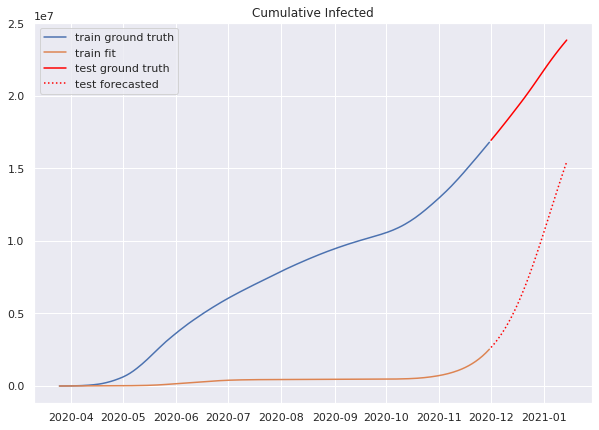

In [227]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'].cumsum(), label='train ground truth')
plt.plot(train_subset.date, I.cumsum(), label='train fit')

plt.plot(test_subset.date, train_subset['infected'].sum()+test_subset['infected'].cumsum(), label='test ground truth', color='red')
plt.plot(test_subset.date, I.sum()+test_I.cumsum(), label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Cumulative Infected')
plt.show()

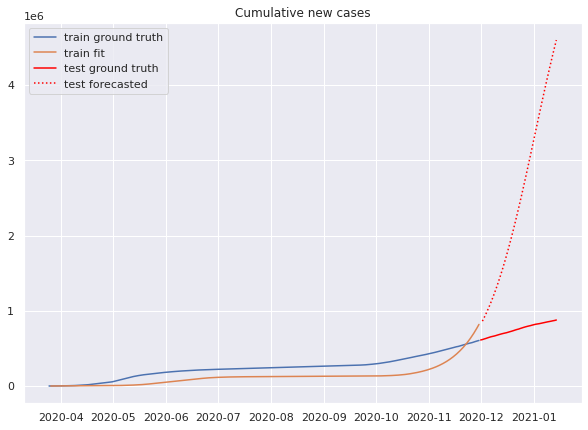

In [228]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected_per_day'].cumsum(), label='train ground truth')
plt.plot(train_subset.date, (pd.Series(I).diff() + pd.Series(R).diff() + pd.Series(D).diff()).cumsum(), label='train fit')

plt.plot(test_subset.date, train_subset['infected_per_day'].sum()+test_subset['infected_per_day'].cumsum(), label='test ground truth', color='red')
plt.plot(test_subset.date,  (pd.Series(I).diff() + pd.Series(R).diff() + pd.Series(D).diff()).sum()+(pd.Series(test_I).diff() + pd.Series(test_R).diff() + pd.Series(test_D).diff()).cumsum(), label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Cumulative new cases')
plt.show()

# Future forecast

In [229]:
future_dates = pd.date_range(start=df.iloc[-1].date, periods=365//2)

future_t = np.arange(test_t[-1], test_t[-1]+len(future_dates))

assert len(future_dates) == len(future_t)

In [230]:
test_future_t = np.concatenate([test_t, future_t])

In [231]:
(future_S, future_E, future_I, future_R, future_D), history = model.predict_test(test_future_t)

future_S, future_E, future_I, future_R, future_D = future_S[len(test_t):], future_E[len(test_t):], future_I[len(test_t):], future_R[len(test_t):], future_D[len(test_t):]

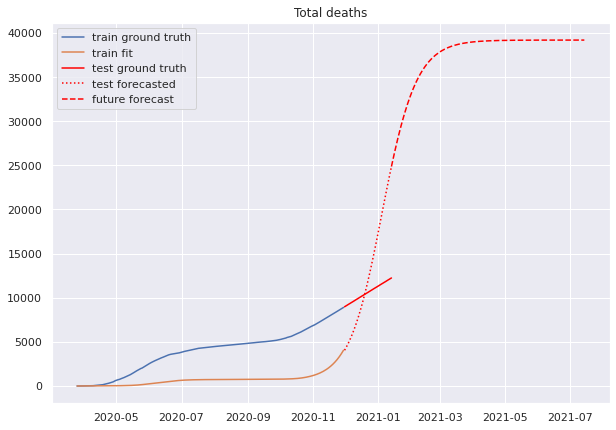

In [232]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='train ground truth')
plt.plot(train_subset.date, D, label='train fit')

plt.plot(test_subset.date, test_subset['total_dead'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_D, label='test forecasted', color='red', linestyle=':')

plt.plot(future_dates, future_D, label='future forecast', color='red', linestyle='--')
plt.legend()
plt.title('Total deaths')
plt.show()

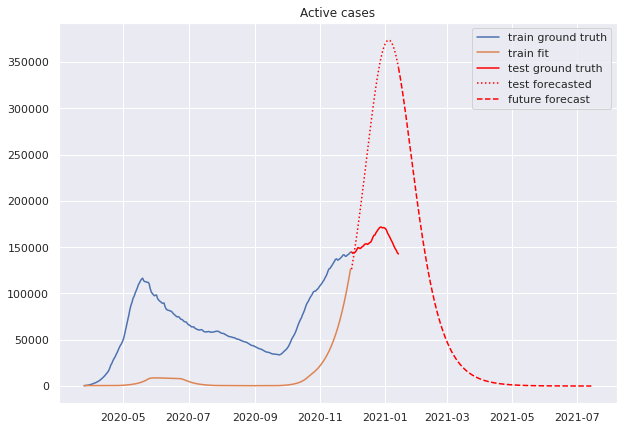

In [233]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='train ground truth')
plt.plot(train_subset.date, I, label='train fit')

plt.plot(test_subset.date, test_subset['infected'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_I, label='test forecasted', color='red', linestyle=':')

plt.plot(future_dates, future_I, label='future forecast', color='red', linestyle='--')
plt.legend()
plt.title('Active cases')
plt.show()